In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [125]:
# Calculate the price,delta and gamma of a put option, tau is the time to maturity of the option
def put_price(SS, KK, tau, rr, sigma):
    dp = (np.log(SS/KK)+(rr+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    dm = (np.log(SS/KK)+(rr-0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    price = K*np.exp(-rr*tau)*norm.cdf(-dm) - SS*norm.cdf(-dp)
    return price

def put_delta(SS, KK, tau, rr, sigma):
    dp = (np.log(SS/KK)+(rr+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    delta = norm.cdf(dp)-1
    return delta

def gammaf(SS, KK, tau, rr, sigma):
    dp = (np.log(SS/KK)+(rr+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    gam = norm.pdf(dp)/(SS*sigma*np.sqrt(tau))
    return gam
                        
# Calculate the price,delta of a call option
def call_price(SS, KK, tau, rr, sigma):
    dp = (np.log(SS/KK)+(rr+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    dm = (np.log(SS/KK)+(rr-0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    price = SS*norm.cdf(dp) - K*np.exp(-rr*tau)*norm.cdf(dm)
    return price

def call_delta(SS, KK, tau, rr, sigma):
    dp = (np.log(SS/KK)+(rr+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    delta = norm.cdf(dp)
    return delta
                                                        

# simlulate the stock price using GBM
def stock_simulation(SS,mumu,sigma,T,Ndt,Nsims):
    S = np.zeros((Nsims,Ndt+1))
    S[:,0] = SS
    tt = np.linspace(0,T,Ndt+1)
    dt = tt[1]-tt[0]
    for i in range(Ndt):
        dw = np.sqrt(dt) * np.random.randn(Nsims)
        S[:,i+1] = S[:,i] * np.exp((mumu-0.5*sigma**2)*dt+sigma*dw)
    return S

## code for plotting graphs - directly copied from the example
def KDE(data, z, fac=1):
    h = 1.069*np.std(data)* (data.shape[0])**(-1/5) * fac
    pdf = np.zeros(z.shape[0])
    ndata = data.shape[0]
    for i in range(ndata):
        pdf += (1.0/ndata)* norm.pdf((z-data[i])/h)/h
    return pdf
def ComputeMetrics(PnL):
    mean_PnL = np.mean(PnL)
    med_PnL = np.median(PnL)
    std_PnL = np.std(PnL)
    VaR = np.quantile(PnL,0.1)
    CVaR = np.mean(PnL[PnL<=VaR])
    return mean_PnL, med_PnL, std_PnL, VaR, CVaR
def PlotMetrics(PnL,mytitle):    
    mean_PnL, med_PnL,  std_PnL, VaR, CVaR =  ComputeMetrics(PnL)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.annotate('E[PnL] = ' + str(round(mean_PnL,3)), xy=(1.05,0.9), xycoords='axes fraction')
    ax.annotate('med(PnL) = ' + str(round(med_PnL,3)), xy=(1.05,0.8), xycoords='axes fraction')
    ax.annotate('std(PnL) = ' + str(round(std_PnL,3)), xy=(1.05,0.7), xycoords='axes fraction')
    ax.annotate('VaR(PnL) = ' + str(round(VaR,3)), xy=(1.05,0.6), xycoords='axes fraction')
    ax.annotate('CVaR(PnL) = ' + str(round(CVaR,3)), xy=(1.05,0.5), xycoords='axes fraction')
    hist_bins = np.linspace(-0.5,0.5,20)
    ax.hist(PnL, bins=hist_bins, alpha=0.7)
    kde_bins = np.linspace(-0.5,0.5,100)
    kde = KDE(PnL, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde)
    ax.plot(kde_bins[kde_bins<=VaR], kde[kde_bins<=VaR], color="red", alpha=0.8)
    ax.fill_between( kde_bins[kde_bins<=VaR], kde[kde_bins<=VaR], color="red", alpha=0.5)
    plt.title(mytitle)
    plt.show()
def PlotMetrics2(cost,mytitle):    
    mean_PnL, med_PnL,  std_PnL,xx,xxx =  ComputeMetrics(cost)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.annotate('E[TransCost] = ' + str(round(mean_PnL,3)), xy=(1.05,0.9), xycoords='axes fraction')
    ax.annotate('med(TransCost) = ' + str(round(med_PnL,3)), xy=(1.05,0.8), xycoords='axes fraction')
    ax.annotate('std(TransCost) = ' + str(round(std_PnL,3)), xy=(1.05,0.7), xycoords='axes fraction')
    hist_bins = np.linspace(-0.01,0.08,20)
    ax.hist(cost, bins=hist_bins, alpha=0.5)
    kde_bins = np.linspace(-0.01,0.08,100)
    kde = KDE(cost, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde)
    plt.title(mytitle)
    plt.show()

## Q1

In [4]:
S0  = 100
K   = 100  #Strike price
sig = 0.2  #Volatility
mu  = 0.1 
r   = 0.02 #Risk-free rate
T1  = 0.25 #Maturity of put
T2  = 0.5  #Maturity of call
cost_e = 0.005 #Equity transaction cost
cost_o = 0.01  #Option transaction cost

In [5]:
Ndt_1 = 100
Nsims_1 = 1000
timestep_1 = 100
mystock = stock_simulation(S0,mu,sig,T1,Ndt_1,Nsims_1)

In [6]:
## Q1
## delta-hedging ==> time-based
def map_time_arrays(t1,t2):
    t3 = np.copy(t1)
    for i in range(len(t1)):
        for j in range(len(t2)):
            if t1[i] > t2[j] and t1[i] <= t2[j+1]:
                t3[i] = t2[j]
    return np.vstack((t1,t3))

In [7]:
def DeltaHedge(S,S0, mumu, sigma, rr, KK, T, Ndt, timestep, Nsims, trans_cost_equity, trans_cost_option, bandwidth): 
    # timestep is the number of timesteps in the time-based hedging; S is the simulated stock prices
    # compute the price of the option and simulate stock 
    price = put_price(S0,KK,T,rr,sigma)
    
    # set up spaces to store results
    delta  = np.zeros((Nsims, Ndt+1))
    time_Y = np.zeros((Nsims, Ndt+1)) # for bank account
    move_Y = np.zeros((Nsims, Ndt+1))
    time_alpha = np.zeros((Nsims, Ndt+1)) # alpha is the position of the stock  
    move_alpha = np.zeros((Nsims, Ndt+1))
    time_alpha[:-1] = np.NaN #at terminal time we don't rebalance, so we don't need alpha[:,-1]
    move_alpha[:-1] = np.NaN
    band  = np.zeros((2,Nsims))
    
    #the initial position in the stock
    time_alpha[:,0] = put_delta(S[:,0], KK, T, rr, sigma) # initialize the position in the asset
    time_Y[:,0]     = price - trans_cost_option - time_alpha[:,0] * S[:,0] - np.abs(time_alpha[:,0]) * trans_cost_equity # initialize the bank account - transaction cost included
    
    move_alpha[:,0]=put_delta(S[:,0],KK, T, rr, sigma)
    move_Y[:,0] =price-trans_cost_option - move_alpha[:,0]*S[:,0]-np.abs(move_alpha[:,0])*trans_cost_equity
    
    delta[:,0] = put_delta(S[:,0], KK, T, rr, sigma)
    
    band[0]    = put_delta(S[:,0], KK, T, rr, sigma) - bandwidth/2
    band[1]    = put_delta(S[:,0], KK, T, rr, sigma) + bandwidth/2
    #create time grid
    t1 = np.linspace(0,T,Ndt+1) 
    dt1 = t1[1] - t1[0] 
    t2 = np.linspace(0,T,timestep+1) 
    t3 = map_time_arrays(t1,t2)

    transcost_time = (np.abs(time_alpha[:,0]) * trans_cost_equity + trans_cost_option) * np.exp(rr*T)
    transcost_move = (np.abs(time_alpha[:,0]) * trans_cost_equity + trans_cost_option) * np.exp(rr*T)
    # step in time, stop only when rebalance needed
    for i in range(Ndt):
        if i < Ndt - 1:
            delta[:,i+1] = put_delta(S[:,i+1], KK, T-t1[i+1], rr, sigma)
            if t3[1,i] < t3[1,i+1]:
                time_alpha[:, i+1] = put_delta(S[:,i+1], KK, T-t1[i+1], rr, sigma)
                time_Y[:, i+1]     = time_Y[:,i] * np.exp(rr*dt1) - (time_alpha[:,i+1] - time_alpha[:,i]) \
                                      * S[:,i+1] - trans_cost_equity * np.abs(time_alpha[:,i+1] - time_alpha[:,i])
                transcost_time = (transcost_time + (trans_cost_equity * np.abs(time_alpha[:,i+1] - time_alpha[:,i]))) * \
                                                                                                     np.exp(rr*(T-t1[i+1]))
            else:
                time_alpha[:,i+1]  = time_alpha[:,i]
                time_Y[:,i+1]      = time_Y[:,i] * np.exp(rr*dt1)
                transcost_time     = transcost_time * np.exp(rr*(T-t1[i+1]))
            for j in range(Nsims):
        
                    if delta[j,i+1] > band[0][j] and delta[j,i+1] < band[1][j]:
                        move_alpha[j,i+1] = move_alpha[j,i]
                        move_Y[j,i+1]     = move_Y[j,i] * np.exp(rr*dt1)
                        
                    else:
                        move_alpha[j,i+1] = delta[j,i+1]
                        move_Y[j,i+1]     = move_Y[j,i] * np.exp(rr*dt1)-(move_alpha[j,i+1]-move_alpha[j,i])\
                                            * S[j,i+1] - trans_cost_equity * np.abs(move_alpha[j,i+1] - move_alpha[j,i])
                        band[0][j]        = delta[j,i+1] - bandwidth/2
                        band[1][j]        = delta[j,i+1] + bandwidth/2
            transcost_move = (transcost_move + (trans_cost_equity * np.abs(move_alpha[:,i+1] - move_alpha[:,i]))) *\
                                                                                                                np.exp(rr*(T-t1[i+1]))                                
                
    payoff = KK - S[:,-1]
    payoff[payoff<0] = 0
    
    time_Y[:,-1] = time_Y[:,-2]* np.exp(rr*dt1) + time_alpha[:,-2] * S[:,-1] - np.abs(time_alpha[:,-2]) * trans_cost_equity
    move_Y[:,-1] = move_Y[:,-2]* np.exp(rr*dt1) + move_alpha[:,-2] * S[:,-1] - np.abs(move_alpha[:,-2]) * trans_cost_equity
    
    transcost_time = transcost_time + np.abs(time_alpha[:,-2]) * trans_cost_equity
    transcost_move = transcost_move + np.abs(move_alpha[:,-2]) * trans_cost_equity
    
    time_PnL = time_Y[:,-1] - payoff
    move_PnL = move_Y[:,-1] - payoff
    
    move_BV = move_Y + S * move_alpha 
    time_BV = time_Y + S * time_alpha
    
    time_BV[:,-1] = time_Y[:,-1] + np.abs(time_alpha[:,-2]) * trans_cost_equity
    move_BV[:,-1] = move_Y[:,-1] + np.abs(move_alpha[:,-2]) * trans_cost_equity
    
    return t1,price,S,time_Y,move_Y, time_alpha, move_alpha,time_PnL,move_PnL,move_BV,time_BV,transcost_time,transcost_move

In [8]:
## delta hedging when time-step = 100
t, price, S, time_Y, move_Y, time_alpha, move_alpha, time_PnL, move_PnL, move_BV,time_BV,transcost_time,transcost_move \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.05)

In [9]:
## delta hedging when timestep=50
t_50, price_50, S_50, time_Y_50, move_Y_50, time_alpha_50, move_alpha_50, time_PnL_50, move_PnL_50, move_BV_50\
                              ,time_BV_50,transcost_time_50,transcost_move_50 \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,50,Nsims_1,cost_e,cost_o,0.05)

In [10]:
## delta hedging when timestep=20
t_20, price_20, S_20, time_Y_20, move_Y_20, time_alpha_20, move_alpha_20, time_PnL_20, move_PnL_20, move_BV_20\
                              ,time_BV_20,transcost_time_20,transcost_move_20 \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,20,Nsims_1,cost_e,cost_o,0.05)

In [247]:
payoff1 = 100 - mystock[:,-1]
payoff1[payoff1<0]=0
print(np.mean(move_BV[:,-1]-payoff1))
print(np.mean(time_BV[:,-1] - payoff1))
print(np.mean(time_BV_50[:,-1]-payoff1))
print(np.mean(time_BV_20[:,-1]-payoff1))
print(np.mean(transcost_move))
print(np.mean(transcost_time))
print(np.mean(transcost_time_50))
print(np.mean(transcost_time_20))

-0.015662282156725143
-0.023039716506967723
-0.037002253268814074
-0.02785202086043719
0.03296211128644782
0.035036234565288406
0.03015817535815396
0.02549194693498955


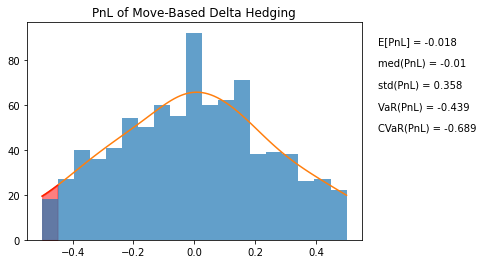

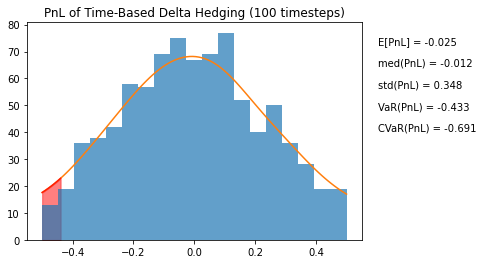

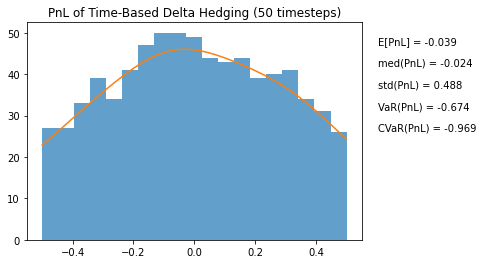

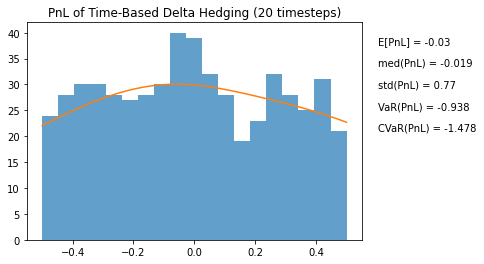

In [11]:
# PnL Plots - delta hedging
PlotMetrics(move_PnL,"PnL of Move-Based Delta Hedging")
PlotMetrics(time_PnL,"PnL of Time-Based Delta Hedging (100 timesteps)")
PlotMetrics(time_PnL_50,"PnL of Time-Based Delta Hedging (50 timesteps)")
PlotMetrics(time_PnL_20,"PnL of Time-Based Delta Hedging (20 timesteps)")

In [194]:
def PlotMetrics_d_PnL(PnL1,PnL2,PnL3,PnL4,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-0.5,0.5,100)
    hist_bins = np.linspace(-0.5,0.5,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.legend(['Move-Based Delta Hedging','Time-Based Delta Hedging (100 timesteps)',\
               'Time-Based Delta Hedging (50 timesteps)','Time-Based Delta Hedging (20 timesteps)'],\
                 bbox_to_anchor=(1.8,1),loc="upper right")
    
    plt.title(mytitle)
    plt.show()

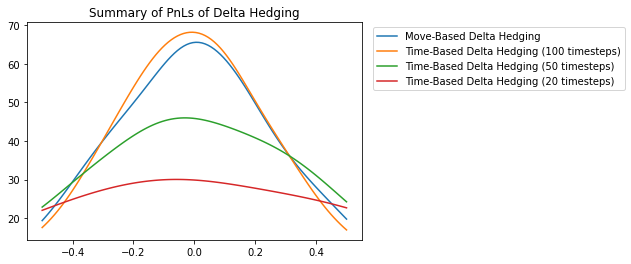

In [196]:
PlotMetrics_d_PnL(move_PnL,time_PnL,time_PnL_50,time_PnL_20,"Summary of PnLs of Delta Hedging")

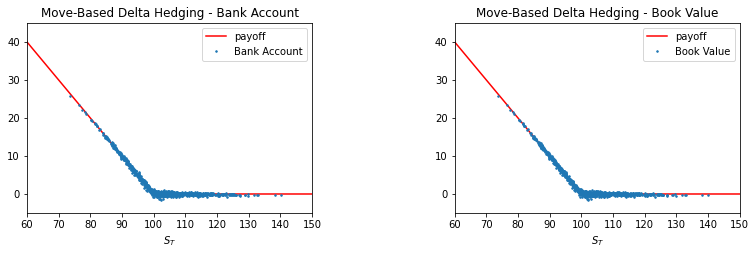

In [12]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging - Bank Account')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging - Book Value')

plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.5,hspace=1)

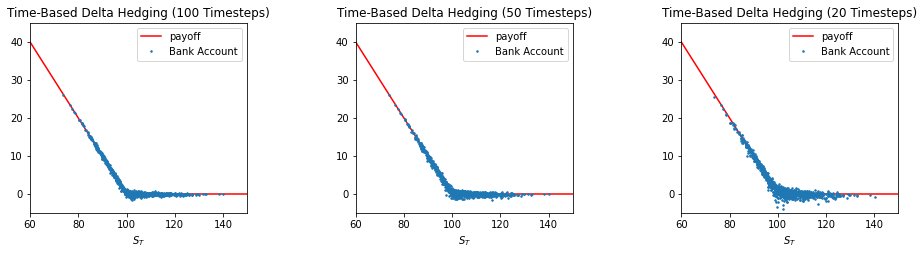

In [13]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_Y[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_Y_50[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_Y_20[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (20 Timesteps)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

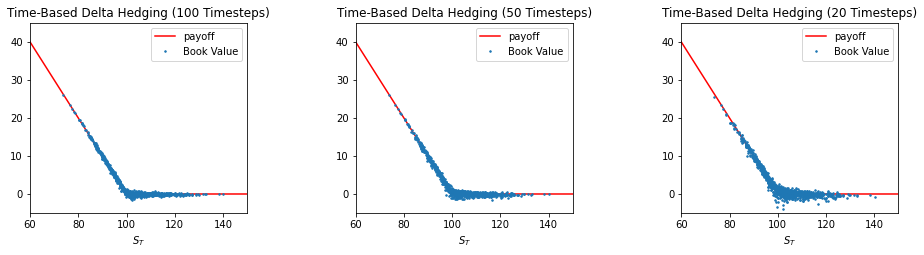

In [14]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_BV[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_BV_50[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_BV_20[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (20 Timesteps)')

plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

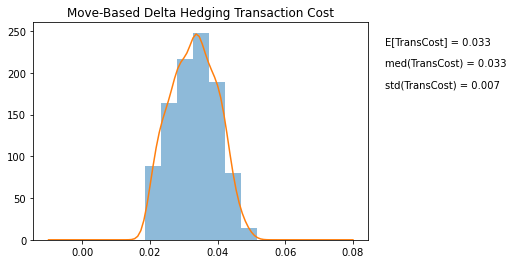

In [126]:
PlotMetrics2(transcost_move,"Move-Based Delta Hedging Transaction Cost")

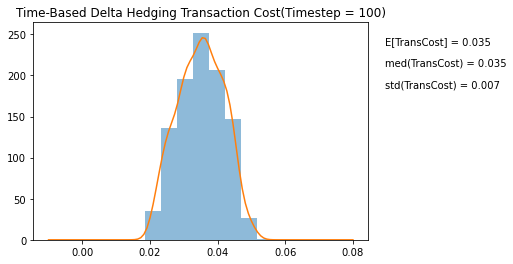

In [127]:
PlotMetrics2(transcost_time,"Time-Based Delta Hedging Transaction Cost(Timestep = 100)")

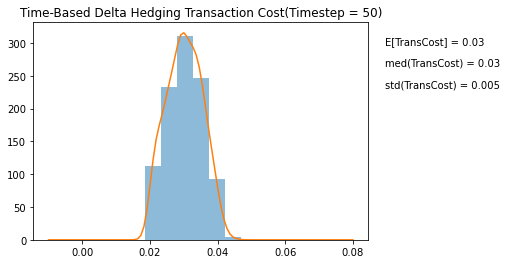

In [128]:
PlotMetrics2(transcost_time_50,"Time-Based Delta Hedging Transaction Cost(Timestep = 50)")

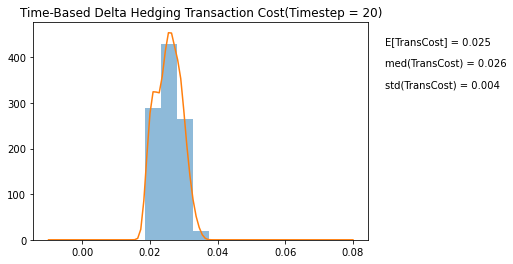

In [129]:
PlotMetrics2(transcost_time_20,"Time-Based Delta Hedging Transaction Cost(Timestep = 20)")

## Q2

In [157]:
def DeltaGammaHedge(S,SS0,mumu,sigma,rr,KK,T,TT,Ndt,timestep,Nsims,trans_cost_equity, trans_cost_option, bandwidth): 
    price_p = put_price(SS0,KK,T,rr,sigma)
    
    time_call = np.zeros((Nsims, Ndt+1))
    move_call = np.zeros((Nsims, Ndt+1))
    time_Y    = np.zeros((Nsims, Ndt+1))
    move_Y    = np.zeros((Nsims, Ndt+1))
    time_alpha = np.zeros((Nsims, Ndt+1)) # alpha is the position of the stock  
    move_alpha = np.zeros((Nsims, Ndt+1))
    time_gamma = np.zeros((Nsims, Ndt+1))
    move_gamma = np.zeros((Nsims, Ndt+1))
    delta = np.zeros((Nsims, Ndt+1))
    
    band  = np.zeros((2,Nsims))
    
    time_alpha[:-1] = np.NaN
    move_alpha[:-1] = np.NaN
    time_gamma[:-1] = np.NaN
    move_gamma[:-1] = np.NaN
    time_call[:,0]  = call_price(SS0,KK,TT,rr,sigma)
    move_call[:,0]  = call_price(SS0,KK,TT,rr,sigma)
    time_alpha[:,0] = put_delta(S[:,0], KK, T, rr, sigma)-gammaf(S[:,0], KK, T, rr, sigma)/gammaf(S[:,0], KK, TT, rr, sigma) \
                                                                                   * call_delta(S[:,0], KK, TT, rr, sigma)
    move_alpha[:,0] = put_delta(S[:,0], KK, T, rr, sigma)-gammaf(S[:,0], KK, T, rr, sigma)/gammaf(S[:,0], KK, TT, rr, sigma) \
                                                                                   * call_delta(S[:,0], KK, TT, rr, sigma)
    time_gamma[:,0] = gammaf(S[:,0], KK, T, rr, sigma)/gammaf(S[:,0], KK, TT, rr, sigma)
    move_gamma[:,0] = gammaf(S[:,0], KK, T, rr, sigma)/gammaf(S[:,0], KK, TT, rr, sigma)
    time_Y[:,0]     = price_p - time_alpha[:,0] * S[:,0] - np.abs(time_alpha[:,0]) * trans_cost_equity \
    - call_price(SS0,KK,TT,rr,sigma)*time_gamma[:,0] - trans_cost_option*(1+np.abs(time_gamma[:,0]))
    move_Y[:,0]     = price_p - move_alpha[:,0] * S[:,0] - np.abs(move_alpha[:,0]) * trans_cost_equity \
    - call_price(SS0,KK,TT,rr,sigma)*move_gamma[:,0] - trans_cost_option*(1+np.abs(move_gamma[:,0]))
    
    transcost_time = (np.abs(time_alpha[:,0]) * trans_cost_equity + trans_cost_option*(1+np.abs(time_gamma[:,0]))) * np.exp(rr*T) 
    transcost_move = (np.abs(move_alpha[:,0]) * trans_cost_equity + trans_cost_option*(1+np.abs(move_gamma[:,0]))) * np.exp(rr*T)
    #create time grid
    t1  = np.linspace(0,T,Ndt+1) 
    dt1 = t1[1] - t1[0]
    t2  = np.linspace(0,T,timestep+1) 
    t3  = map_time_arrays(t1,t2)
    
    for i in range(Ndt):
        if i < Ndt - 1:
            delta[:,i+1] = put_delta(S[:,i+1], KK, T-t1[i+1], rr, sigma)
            if t3[1,i] < t3[1,i+1]:
                time_alpha[:,i+1] = put_delta(S[:,i+1], KK, T-t1[i+1], rr, sigma) \
                               - gammaf(S[:,i+1],KK,T-t1[i+1],rr,sigma)/gammaf(S[:,i+1],KK,TT-t1[i+1],rr,sigma)\
                               * call_delta(S[:,i+1],KK,TT-t1[i+1],rr,sigma)
                time_gamma[:,i+1] = gammaf(S[:,i+1],KK,T-t1[i+1],rr,sigma)/gammaf(S[:,i+1],KK,TT-t1[i+1],rr,sigma)
                time_call[:,i+1]  = call_price(S[:,i+1],KK,TT-t1[i+1],rr,sigma)
                time_Y[:,i+1]     = time_Y[:,i] * np.exp(rr*dt1) - (time_alpha[:,i+1] - time_alpha[:,i]) * S[:,i+1] \
                               - (time_gamma[:,i+1] - time_gamma[:,i]) * time_call[:,i+1] \
                               - trans_cost_equity*np.abs(time_alpha[:,i+1] - time_alpha[:,i]) \
                               - trans_cost_option*np.abs(time_gamma[:,i+1] - time_gamma[:,i])
                transcost_time = (transcost_time + trans_cost_equity*np.abs(time_alpha[:,i+1] - time_alpha[:,i]) +\
                                  trans_cost_option*np.abs(time_gamma[:,i+1] - time_gamma[:,i])) * np.exp(rr*(T-t1[i+1]))
            else:
                time_alpha[:,i+1] = time_alpha[:,i]
                time_gamma[:,i+1] = time_gamma[:,i]
                time_call[:,i+1]  = call_price(S[:,i+1],KK,TT-t1[i+1],rr,sigma)
                time_Y[:,i+1]     = time_Y[:,i]*np.exp(rr*dt1)
                transcost_time    = transcost_time*np.exp(rr*(T-t1[i+1]))
                
            for j in range(Nsims):
                    move_alpha[:,i+1][j] = put_delta(S[j,i+1], KK, T-t1[i+1], rr, sigma) \
                               - gammaf(S[j,i+1],KK,T-t1[i+1],rr,sigma)/gammaf(S[j,i+1],KK,TT-t1[i+1],rr,sigma)\
                               * call_delta(S[j,i+1],KK,TT-t1[i+1],rr,sigma)

                    if move_alpha[:,i+1][j] > band[0][j] and move_alpha[:,i+1][j] < band[1][j]: 
                        move_alpha[:,i+1][j] = move_alpha[:,i][j]
                        move_gamma[:,i+1][j] = move_gamma[:,i][j]
                        move_call[:,i+1][j]  = (call_price(S[:,i+1],KK,TT-t1[i+1],rr,sigma))[j]
                        move_Y[:,i+1][j]     = move_Y[:,i][j]*np.exp(rr*dt1)
                    else:
                        move_gamma[:,i+1][j] = gammaf(S[j,i+1],KK,T-t1[i+1],rr,sigma)/gammaf(S[j,i+1],KK,TT-t1[i+1],rr,sigma)
                        move_call[:,i+1][j]  = (call_price(S[:,i+1],KK,TT-t1[i+1],rr,sigma))[j]
                        move_Y[j,i+1]     = move_Y[j,i] * np.exp(rr*dt1) - (move_alpha[j,i+1] - move_alpha[j,i]) * S[j,i+1] \
                               - (move_gamma[j,i+1] - move_gamma[j,i]) * move_call[j,i+1] \
                               - trans_cost_equity*np.abs(move_alpha[j,i+1] - move_alpha[j,i]) \
                               - trans_cost_option*np.abs(move_gamma[j,i+1] - move_gamma[j,i])
                        band[0][j]      = move_alpha[:,i+1][j] - bandwidth/2
                        band[1][j]      = move_alpha[:,i+1][j] + bandwidth/2
                        
            transcost_move  = (transcost_move + trans_cost_equity*np.abs(move_alpha[:,i+1] - move_alpha[:,i]) +\
                                           trans_cost_option*np.abs(move_gamma[:,i+1] - move_gamma[:,i]))*np.exp(rr*(T-t1[i+1]))
            
       
    payoff = KK - S[:,-1]
    payoff[payoff<0] = 0
    
    time_Y[:,-1] = time_Y[:,-2]* np.exp(rr*dt1) + time_alpha[:,-2] * S[:,-1] - np.abs(time_alpha[:,-2]) * trans_cost_equity \
                                       + time_gamma[:,-2] * call_price(S[:,-1],KK,TT-T,rr,sigma) \
                                       - np.abs(time_gamma[:,-2]) * trans_cost_option
    move_Y[:,-1] = move_Y[:,-2]* np.exp(rr*dt1) + move_alpha[:,-2] * S[:,-1] - np.abs(move_alpha[:,-2]) * trans_cost_equity \
                                       + move_gamma[:,-2] * call_price(S[:,-1],KK,TT-T,rr,sigma) \
                                       - np.abs(move_gamma[:,-2]) * trans_cost_option
    
    transcost_time = transcost_time + np.abs(time_alpha[:,-2]) * trans_cost_equity + np.abs(time_gamma[:,-2]) * trans_cost_option
    transcost_move = transcost_move + np.abs(move_alpha[:,-2]) * trans_cost_equity + np.abs(move_gamma[:,-2]) * trans_cost_option
    
    time_PnL = time_Y[:,-1] - payoff
    move_PnL = move_Y[:,-1] - payoff
    
    move_BV = move_Y + S * move_alpha + move_call * move_gamma
    time_BV = time_Y + S * time_alpha + move_call * move_gamma
    time_BV[:,-1] = time_Y[:,-1] + np.abs(time_alpha[:,-2]) * trans_cost_equity + np.abs(time_gamma[:,-2]) * trans_cost_option
    move_BV[:,-1] = move_Y[:,-1] + np.abs(move_alpha[:,-2]) * trans_cost_equity + np.abs(time_gamma[:,-2]) * trans_cost_option

    return t1,price_p,S,time_Y,move_Y, time_alpha, move_alpha,time_PnL,move_PnL,move_BV,time_BV,transcost_time,transcost_move,\
            time_gamma,move_gamma

In [114]:
# deltagamma hedging when timestep=100
t1x,price_px,Sx,time_Yx,move_Yx, time_alphax, move_alphax,time_PnLx,move_PnLx,move_BVx,time_BVx,transcost_timex,transcost_movex,time_gammax,\
 move_gammax=\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.05)
# deltagamma hedging when timestep=50
t_50g,price_50g,S_50g,time_Y_50g,move_Y_50g, time_alpha_50g, move_alpha_50g,time_PnL_50g,move_PnL_50g,move_BV_50g,time_BV_50g,\
                             transcost_time_50g,transcost_move_50g,time_gamma_50g,move_gamma_50g=\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,50,Nsims_1,cost_e,cost_o,0.05)
# deltagamma hedging when timestep=20
t_20g,price_20g,S_20g,time_Y_20g,move_Y_20g, time_alpha_20g, move_alpha_20g,time_PnL_20g,move_PnL_20g,move_BV_20g,time_BV_20g,\
                             transcost_time_20g,transcost_move_20g,time_gamma_20g,move_gamma_20g =\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,20,Nsims_1,cost_e,cost_o,0.05)

In [248]:
payoff1 = 100 - mystock[:,-1]
payoff1[payoff1<0]=0
print(np.mean(move_BVx[:,-1]-payoff1))
print(np.mean(time_BVx[:,-1] - payoff1))
print(np.mean(time_BV_50g[:,-1]-payoff1))
print(np.mean(time_BV_20g[:,-1]-payoff1))

-0.13617896632610593
-0.14549461317536086
-0.11754556228820216
-0.07992271087749177


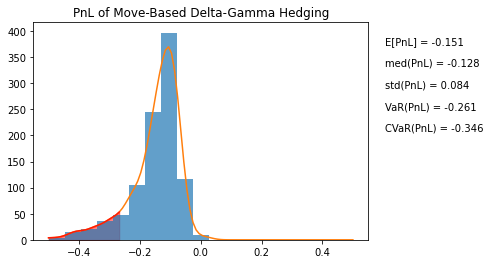

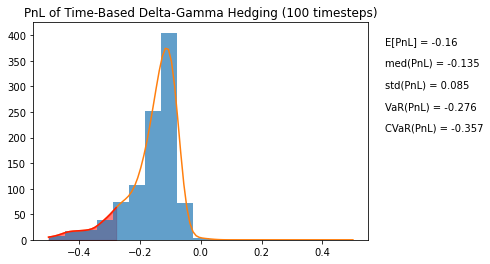

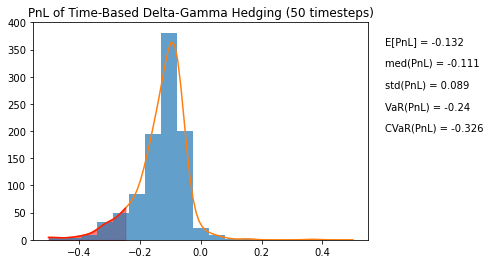

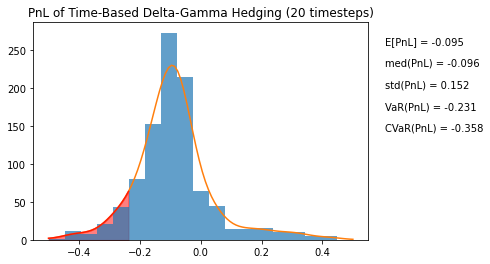

In [197]:
# PnL Plots - deltagamma hedging
PlotMetrics(move_PnLx,"PnL of Move-Based Delta-Gamma Hedging")
PlotMetrics(time_PnLx,"PnL of Time-Based Delta-Gamma Hedging (100 timesteps)")
PlotMetrics(time_PnL_50g,"PnL of Time-Based Delta-Gamma Hedging (50 timesteps)")
PlotMetrics(time_PnL_20g,"PnL of Time-Based Delta-Gamma Hedging (20 timesteps)")

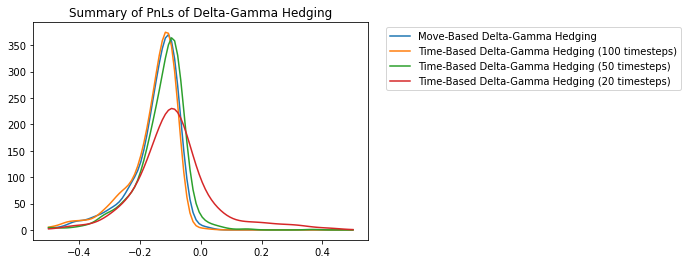

In [278]:
def PlotMetrics_dg_PnL(PnL1,PnL2,PnL3,PnL4,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-0.5,0.5,100)
    hist_bins = np.linspace(-0.5,0.5,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.legend(['Move-Based Delta-Gamma Hedging','Time-Based Delta-Gamma Hedging (100 timesteps)',\
               'Time-Based Delta-Gamma Hedging (50 timesteps)','Time-Based Delta-Gamma Hedging (20 timesteps)'],\
                 bbox_to_anchor=(1.95,1),loc="upper right")
    plt.title(mytitle)
    plt.show()
PlotMetrics_dg_PnL(move_PnLx,time_PnLx,time_PnL_50g,time_PnL_20g,"Summary of PnLs of Delta-Gamma Hedging")

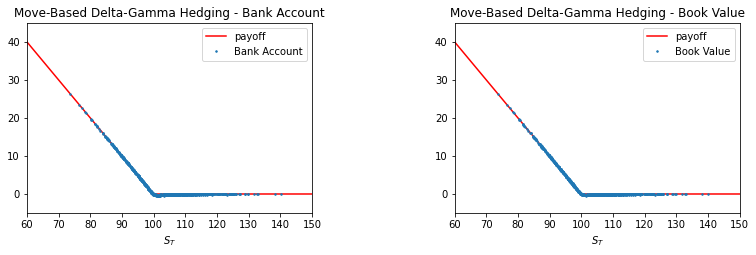

In [116]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Yx[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging - Bank Account')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BVx[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging - Book Value')

plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.5,hspace=1)

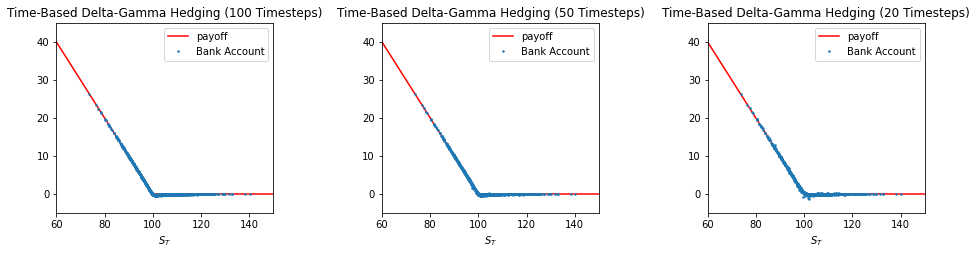

In [117]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_Yx[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_Y_50g[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_Y_20g[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (20 Timesteps)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

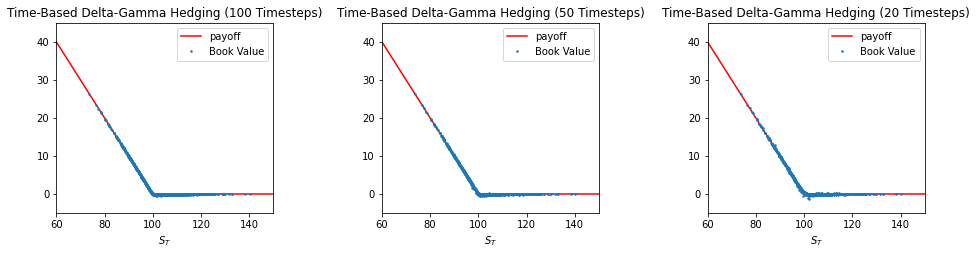

In [118]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_BVx[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_BV_50g[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], time_BV_20g[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (20 Timesteps)')

plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

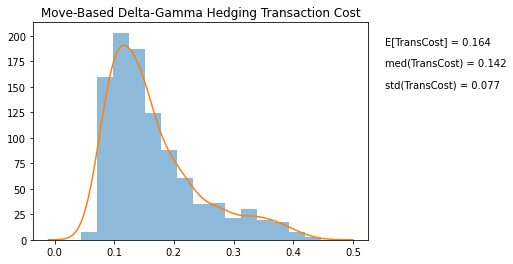

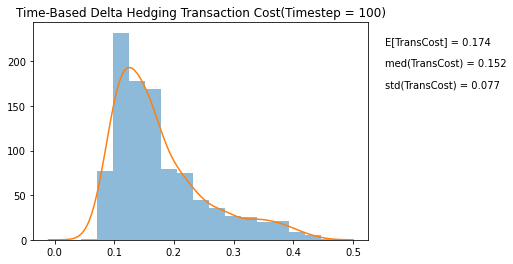

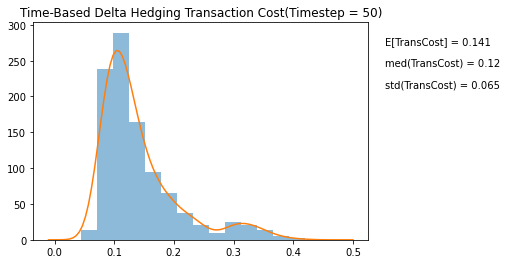

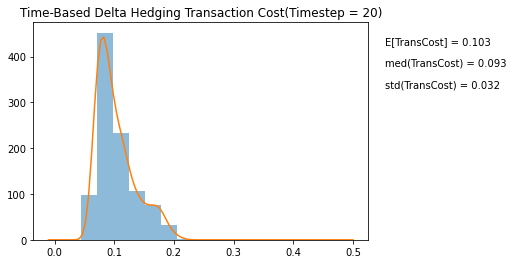

In [143]:
def PlotMetrics3(cost,mytitle):    
    mean_PnL, med_PnL,  std_PnL,xx,xxx =  ComputeMetrics(cost)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.annotate('E[TransCost] = ' + str(round(mean_PnL,3)), xy=(1.05,0.9), xycoords='axes fraction')
    ax.annotate('med(TransCost) = ' + str(round(med_PnL,3)), xy=(1.05,0.8), xycoords='axes fraction')
    ax.annotate('std(TransCost) = ' + str(round(std_PnL,3)), xy=(1.05,0.7), xycoords='axes fraction')
    hist_bins = np.linspace(-0.01,0.5,20)
    ax.hist(cost, bins=hist_bins, alpha=0.5)
    kde_bins = np.linspace(-0.01,0.5,100)
    kde = KDE(cost, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde)
    plt.title(mytitle)
    plt.show()
    
PlotMetrics3(transcost_movex,"Move-Based Delta-Gamma Hedging Transaction Cost")
PlotMetrics3(transcost_timex,"Time-Based Delta Hedging Transaction Cost(Timestep = 100)")
PlotMetrics3(transcost_time_50g,"Time-Based Delta Hedging Transaction Cost(Timestep = 50)")
PlotMetrics3(transcost_time_20g,"Time-Based Delta Hedging Transaction Cost(Timestep = 20)")

## Q3


In [130]:
## generating new stock prices using the real word volatility p_sigma = 0.15
S0  = 100
K   = 100  #Strike price
mu  = 0.1 
r   = 0.02 #Risk-free rate
T1  = 0.25 #Maturity of put
T2  = 0.5  #Maturity of call
cost_e = 0.005 #Equity transaction cost
cost_o = 0.01  #Option transaction cost
p_sig = 0.15
q_sig = 0.2
mystock2 = stock_simulation(S0,mu,p_sig,T1,100,1000)

In [131]:
## delta hedging with p_sigma = 0.15, q_sigma = 0.2
def DeltaHedge2(S,S0, mumu,q_sigma, rr, KK, T, Ndt, timestep, Nsims, trans_cost_equity, trans_cost_option, bandwidth): 
    # timestep is the number of timesteps in the time-based hedging; S is the simulated stock prices
    # compute the price of the option and simulate stock 
    price = put_price(S0,KK,T,rr,q_sigma)
    
    # set up spaces to store results
    delta  = np.zeros((Nsims, Ndt+1))
    time_Y = np.zeros((Nsims, Ndt+1)) # for bank account
    move_Y = np.zeros((Nsims, Ndt+1))
    time_alpha = np.zeros((Nsims, Ndt+1)) # alpha is the position of the stock  
    move_alpha = np.zeros((Nsims, Ndt+1))
    time_alpha[:-1] = np.NaN #at terminal time we don't rebalance, so we don't need alpha[:,-1]
    move_alpha[:-1] = np.NaN
    band  = np.zeros((2,Nsims))
    
    #the initial position in the stock
    time_alpha[:,0] = put_delta(S[:,0], KK, T, rr, q_sigma) # initialize the position in the asset
    time_Y[:,0]     = price - trans_cost_option - time_alpha[:,0] * S[:,0] - np.abs(time_alpha[:,0]) * trans_cost_equity # initialize the bank account - transaction cost included
    
    move_alpha[:,0]=put_delta(S[:,0],KK, T, rr, q_sigma)
    move_Y[:,0] =price-trans_cost_option - move_alpha[:,0]*S[:,0]-np.abs(move_alpha[:,0])*trans_cost_equity
    
    delta[:,0] = put_delta(S[:,0], KK, T, rr, q_sigma)
    
    band[0]    = put_delta(S[:,0], KK, T, rr, q_sigma) - bandwidth/2
    band[1]    = put_delta(S[:,0], KK, T, rr, q_sigma) + bandwidth/2
    #create time grid
    t1 = np.linspace(0,T,Ndt+1) 
    dt1 = t1[1] - t1[0] 
    t2 = np.linspace(0,T,timestep+1) 
    t3 = map_time_arrays(t1,t2)

    transcost_time = (np.abs(time_alpha[:,0]) * trans_cost_equity + trans_cost_option) * np.exp(rr*T)
    transcost_move = (np.abs(time_alpha[:,0]) * trans_cost_equity + trans_cost_option) * np.exp(rr*T)
    # step in time, stop only when rebalance needed
    for i in range(Ndt):
        if i < Ndt - 1:
            delta[:,i+1] = put_delta(S[:,i+1], KK, T-t1[i+1], rr, q_sigma)
            if t3[1,i] < t3[1,i+1]:
                time_alpha[:, i+1] = put_delta(S[:,i+1], KK, T-t1[i+1], rr, q_sigma)
                time_Y[:, i+1]     = time_Y[:,i] * np.exp(rr*dt1) - (time_alpha[:,i+1] - time_alpha[:,i]) \
                                      * S[:,i+1] - trans_cost_equity * np.abs(time_alpha[:,i+1] - time_alpha[:,i])
                transcost_time = (transcost_time + (trans_cost_equity * np.abs(time_alpha[:,i+1] - time_alpha[:,i]))) * \
                                                                                                     np.exp(rr*(T-t1[i+1]))
            else:
                time_alpha[:,i+1]  = time_alpha[:,i]
                time_Y[:,i+1]      = time_Y[:,i] * np.exp(rr*dt1)
                transcost_time     = transcost_time * np.exp(rr*(T-t1[i+1]))
            for j in range(Nsims):
        
                    if delta[j,i+1] > band[0][j] and delta[j,i+1] < band[1][j]:
                        move_alpha[j,i+1] = move_alpha[j,i]
                        move_Y[j,i+1]     = move_Y[j,i] * np.exp(rr*dt1)
                        
                    else:
                        move_alpha[j,i+1] = delta[j,i+1]
                        move_Y[j,i+1]     = move_Y[j,i] * np.exp(rr*dt1)-(move_alpha[j,i+1]-move_alpha[j,i])\
                                            * S[j,i+1] - trans_cost_equity * np.abs(move_alpha[j,i+1] - move_alpha[j,i])
                        band[0][j]        = delta[j,i+1] - bandwidth/2
                        band[1][j]        = delta[j,i+1] + bandwidth/2
            transcost_move = (transcost_move + (trans_cost_equity * np.abs(move_alpha[:,i+1] - move_alpha[:,i]))) *\
                                                                                                                np.exp(rr*(T-t1[i+1]))                                
                
    payoff = KK - S[:,-1]
    payoff[payoff<0] = 0
    
    time_Y[:,-1] = time_Y[:,-2]* np.exp(rr*dt1) + time_alpha[:,-2] * S[:,-1] - np.abs(time_alpha[:,-2]) * trans_cost_equity
    move_Y[:,-1] = move_Y[:,-2]* np.exp(rr*dt1) + move_alpha[:,-2] * S[:,-1] - np.abs(move_alpha[:,-2]) * trans_cost_equity
    
    transcost_time = transcost_time + np.abs(time_alpha[:,-2]) * trans_cost_equity
    transcost_move = transcost_move + np.abs(move_alpha[:,-2]) * trans_cost_equity
    
    time_PnL = time_Y[:,-1] - payoff
    move_PnL = move_Y[:,-1] - payoff
    
    move_BV = move_Y + S * move_alpha 
    time_BV = time_Y + S * time_alpha
    
    time_BV[:,-1] = time_Y[:,-1] + np.abs(time_alpha[:,-2]) * trans_cost_equity
    move_BV[:,-1] = move_Y[:,-1] + np.abs(move_alpha[:,-2]) * trans_cost_equity
    
    return t1,price,S,time_Y,move_Y, time_alpha, move_alpha,time_PnL,move_PnL,move_BV,time_BV,transcost_time,transcost_move

In [132]:
## delta hedging when time-step = 100
tq, priceq, Sq, time_Yq, move_Yq, time_alphaq, move_alphaq, time_PnLq, move_PnLq, move_BVq,time_BVq,transcost_timeq,transcost_moveq \
                              = DeltaHedge2(mystock2,S0,mu,q_sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.05)
## delta hedging when time-step = 50
tq50, priceq50, Sq50, time_Yq50, move_Yq50, time_alphaq50, move_alphaq,time_PnLq50, move_PnLq50, move_BVq50,time_BVq50,transcost_timeq50,transcost_moveq50 \
                              = DeltaHedge2(mystock2,S0,mu,q_sig,r,K,T1,Ndt_1,50,Nsims_1,cost_e,cost_o,0.05)
## delta hedging when time-step = 20
tq20, priceq20, Sq20, time_Yq20, move_Yq20, time_alphaq20, move_alphaq20,\
time_PnLq20, move_PnLq20, move_BVq20,time_BVq20,transcost_timeq20,transcost_moveq20 \
                              = DeltaHedge2(mystock2,S0,mu,q_sig,r,K,T1,Ndt_1,20,Nsims_1,cost_e,cost_o,0.05)

In [251]:
payoff2 = 100 - mystock2[:,-1]
payoff2[payoff2<0]=0
print(np.mean(move_BVq[:,-1]-payoff2))
print(np.mean(time_BVq[:,-1] - payoff2))
print(np.mean(time_BVq50[:,-1]-payoff2))
print(np.mean(time_BVq20[:,-1]-payoff2))
print(np.mean(transcost_moveq))
print(np.mean(transcost_timeq))
print(np.mean(transcost_timeq50))
print(np.mean(transcost_timeq20))

0.9544209060308221
0.9521436514559946
0.9507145787058809
0.9460585943786364
0.029857154987915854
0.032244373355112335
0.02812850500033732
0.024253158151525483


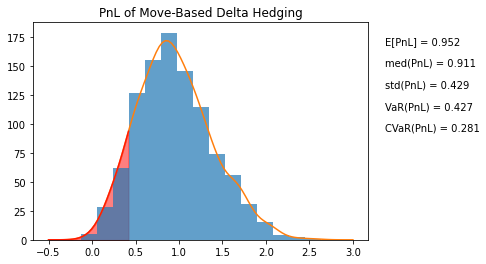

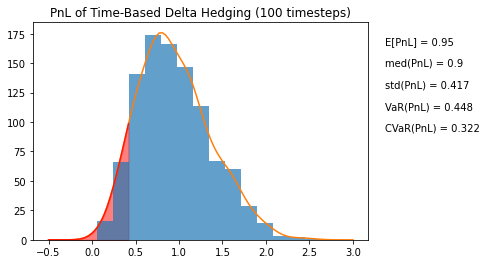

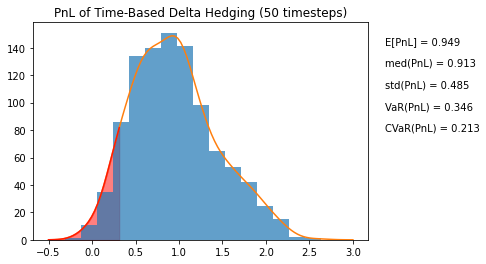

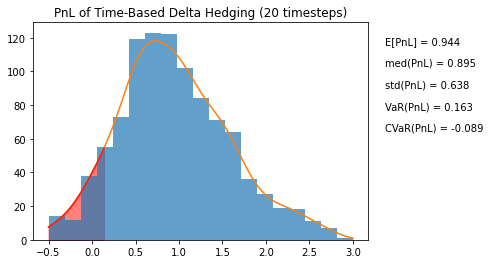

In [142]:
def PlotMetrics4(PnL,mytitle):    
    mean_PnL, med_PnL,  std_PnL, VaR, CVaR =  ComputeMetrics(PnL)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.annotate('E[PnL] = ' + str(round(mean_PnL,3)), xy=(1.05,0.9), xycoords='axes fraction')
    ax.annotate('med(PnL) = ' + str(round(med_PnL,3)), xy=(1.05,0.8), xycoords='axes fraction')
    ax.annotate('std(PnL) = ' + str(round(std_PnL,3)), xy=(1.05,0.7), xycoords='axes fraction')
    ax.annotate('VaR(PnL) = ' + str(round(VaR,3)), xy=(1.05,0.6), xycoords='axes fraction')
    ax.annotate('CVaR(PnL) = ' + str(round(CVaR,3)), xy=(1.05,0.5), xycoords='axes fraction')
    hist_bins = np.linspace(-0.5,3,20)
    ax.hist(PnL, bins=hist_bins, alpha=0.7)
    kde_bins = np.linspace(-0.5,3,100)
    kde = KDE(PnL, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde)
    ax.plot(kde_bins[kde_bins<=VaR], kde[kde_bins<=VaR], color="red", alpha=0.8)
    ax.fill_between( kde_bins[kde_bins<=VaR], kde[kde_bins<=VaR], color="red", alpha=0.5)
    plt.title(mytitle)
    plt.show()
# PnL Plots - delta hedging
PlotMetrics4(move_PnLq,"PnL of Move-Based Delta Hedging")
PlotMetrics4(time_PnLq,"PnL of Time-Based Delta Hedging (100 timesteps)")
PlotMetrics4(time_PnLq50,"PnL of Time-Based Delta Hedging (50 timesteps)")
PlotMetrics4(time_PnLq20,"PnL of Time-Based Delta Hedging (20 timesteps)")

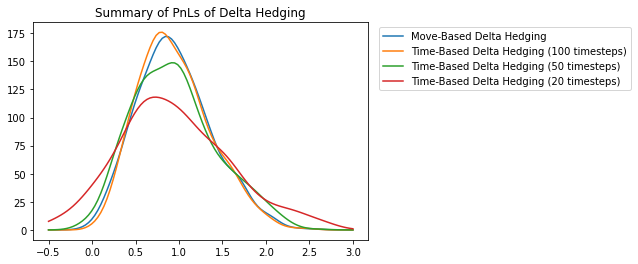

In [277]:
def PlotMetrics_d_PnL_pq(PnL1,PnL2,PnL3,PnL4,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-0.5,3,100)
    hist_bins = np.linspace(-0.5,3,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.legend(['Move-Based Delta Hedging','Time-Based Delta Hedging (100 timesteps)',\
               'Time-Based Delta Hedging (50 timesteps)','Time-Based Delta Hedging (20 timesteps)'],\
                 bbox_to_anchor=(1.8,1),loc="upper right")
    plt.title(mytitle)
    plt.show()
PlotMetrics_d_PnL_pq(move_PnLq,time_PnLq,time_PnLq50,time_PnLq20,"Summary of PnLs of Delta Hedging")

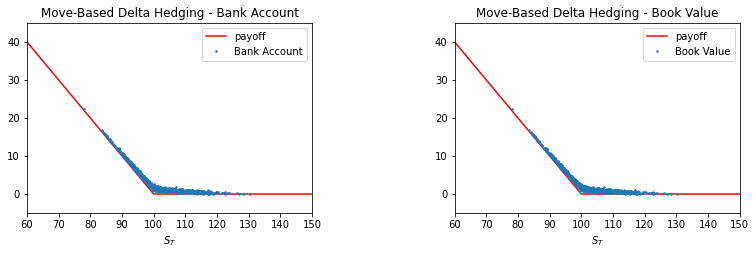

In [134]:
#move-based 
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], move_Yq[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging - Bank Account')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], move_BVq[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging - Book Value')

plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.5,hspace=1)

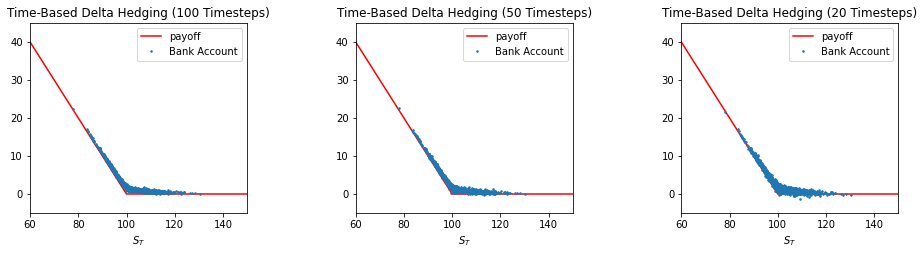

In [135]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_Yq[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_Yq50[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_Yq20[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (20 Timesteps)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

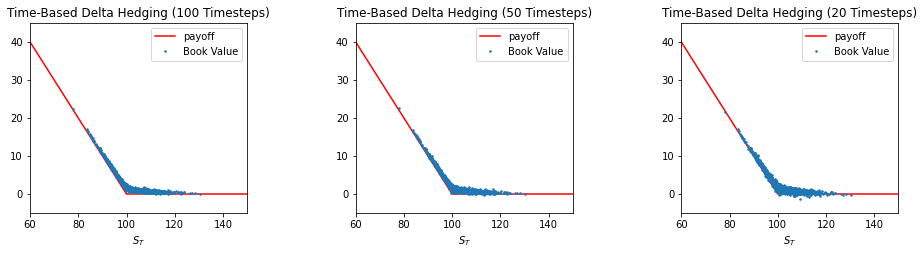

In [136]:
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_BVq[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_BVq50[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_BVq20[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta Hedging (20 Timesteps)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

In [137]:
##deltagamma hedging when p_sigma=0.15, q_sigma=0.2
# deltagamma hedging when timestep=100
t1qg,price_pqg,Sx,time_Yqg,move_Yqg, time_alphaqg, move_alphaqg,time_PnLqg,move_PnLqg,move_BVqg,time_BVqg,transcost_timeqg,transcost_moveqg,\
time_gammaqg,move_gammaqg=\
DeltaGammaHedge(mystock2,S0,mu,q_sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.05)
# deltagamma hedging when timestep=50
t_50qg,price_50qg,S_50qg,time_Y_50qg,move_Y_50qg, \
time_alpha_50qg, move_alpha_50qg,time_PnL_50qg,move_PnL_50qg,move_BV_50qg,time_BV_50qg,\
                             transcost_time_50qg,transcost_move_50qg,time_gamma_50qg,move_gamma_50qg=\
DeltaGammaHedge(mystock2,S0,mu,sig,r,K,T1,T2,Ndt_1,50,Nsims_1,cost_e,cost_o,0.05)
# deltagamma hedging when timestep=20
t_20qg,price_20qg,S_20qg,time_Y_20qg,move_Y_20qg, time_alpha_20qg, move_alpha_20qg,time_PnL_20qg,move_PnL_20qg,move_BV_20qg,time_BV_20qg,\
                             transcost_time_20qg,transcost_move_20qg,time_gamma_20qg,move_gamma_20qg =\
DeltaGammaHedge(mystock2,S0,mu,sig,r,K,T1,T2,Ndt_1,20,Nsims_1,cost_e,cost_o,0.05)

In [250]:
payoff2 = 100 - mystock2[:,-1]
payoff2[payoff2<0]=0
print(np.mean(move_BVqg[:,-1]-payoff2))
print(np.mean(time_BVqg[:,-1] - payoff2))
print(np.mean(time_BV_50qg[:,-1]-payoff2))
print(np.mean(time_BV_20qg[:,-1]-payoff2))

-0.11998269815188282
-0.13064439951662923
-0.10443912578574631
-0.07169815090982719


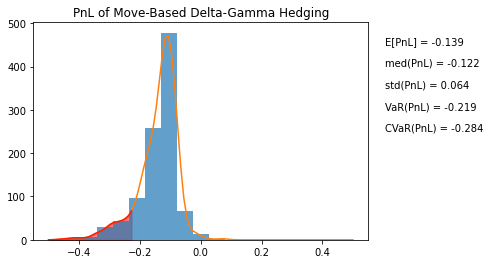

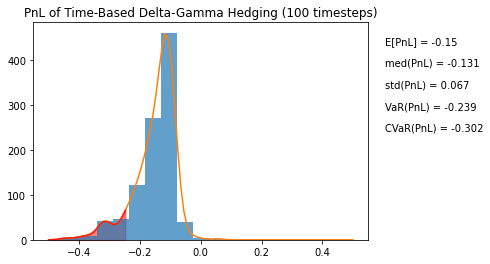

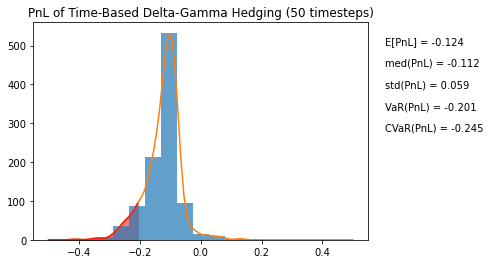

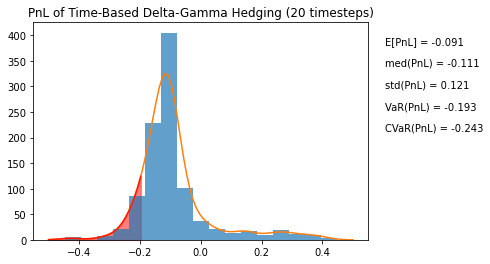

In [138]:
# PnL Plots - deltagamma hedging
PlotMetrics(move_PnLqg,"PnL of Move-Based Delta-Gamma Hedging")
PlotMetrics(time_PnLqg,"PnL of Time-Based Delta-Gamma Hedging (100 timesteps)")
PlotMetrics(time_PnL_50qg,"PnL of Time-Based Delta-Gamma Hedging (50 timesteps)")
PlotMetrics(time_PnL_20qg,"PnL of Time-Based Delta-Gamma Hedging (20 timesteps)")

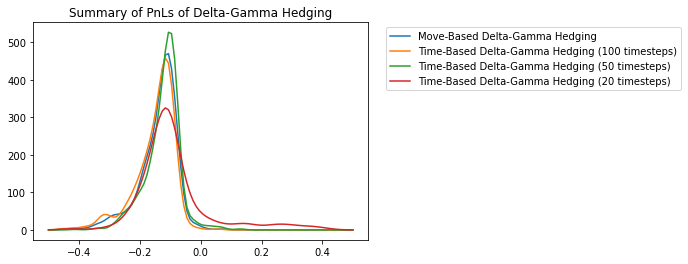

In [276]:
def PlotMetrics_dg_PnL_pq(PnL1,PnL2,PnL3,PnL4,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-0.5,0.5,100)
    hist_bins = np.linspace(-0.5,0.5,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.legend(['Move-Based Delta-Gamma Hedging','Time-Based Delta-Gamma Hedging (100 timesteps)',\
               'Time-Based Delta-Gamma Hedging (50 timesteps)','Time-Based Delta-Gamma Hedging (20 timesteps)'],\
                 bbox_to_anchor=(1.95,1),loc="upper right")
    plt.title(mytitle)
    plt.show()
PlotMetrics_dg_PnL_pq(move_PnLqg,time_PnLqg,time_PnL_50qg,time_PnL_20qg,"Summary of PnLs of Delta-Gamma Hedging")

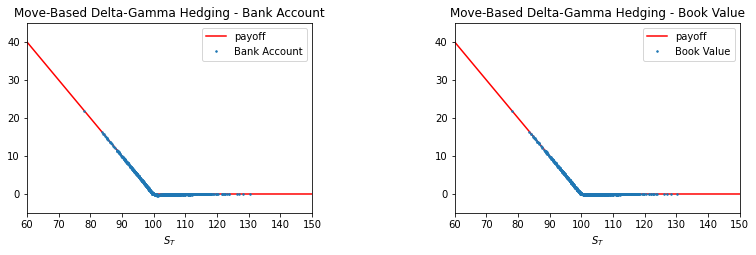

In [139]:
# delta-gamma move-based 
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], move_Yqg[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging - Bank Account')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], move_BVqg[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging - Book Value')

plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.5,hspace=1)

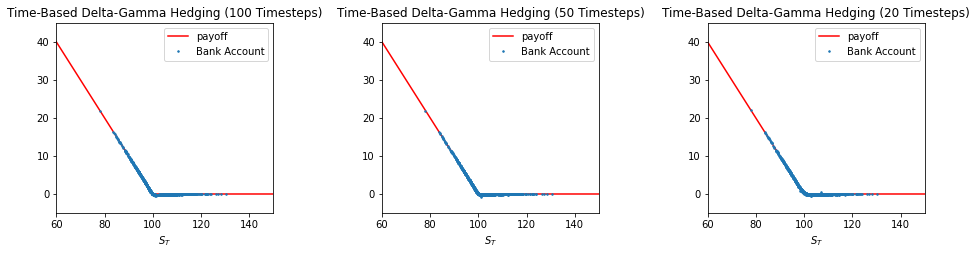

In [140]:
#timebased - bank account
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_Yqg[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_Y_50qg[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_Y_20qg[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (20 Timesteps)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

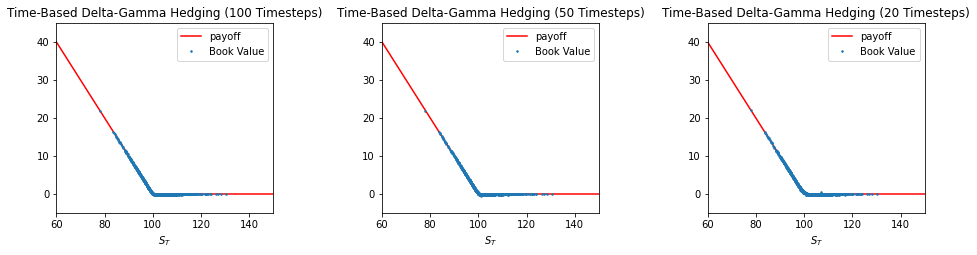

In [141]:
#timebased - BV
plt.figure(figsize=(7.2,7.2))
plt.subplot(2,3,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_BVqg[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (100 Timesteps)')

plt.subplot(2,3,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_BV_50qg[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (50 Timesteps)')

plt.subplot(2,3,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock2[:,-1], time_BV_20qg[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Time-Based Delta-Gamma Hedging (20 Timesteps)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.8,top=1.2,wspace=0.5,hspace=1)

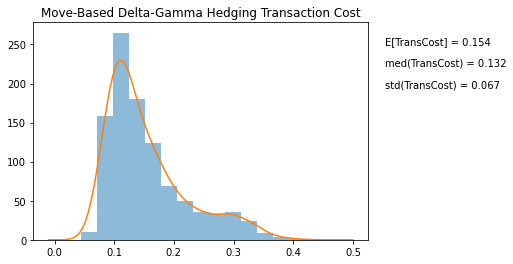

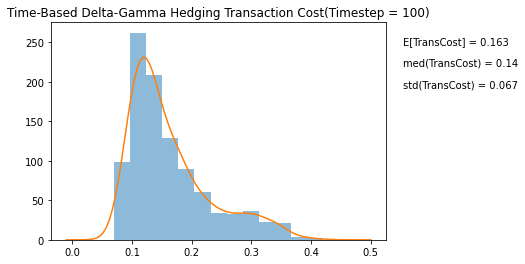

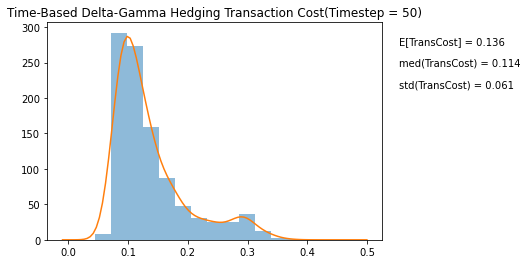

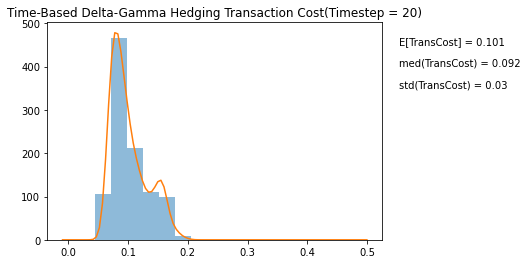

In [145]:
PlotMetrics3(transcost_moveqg,"Move-Based Delta-Gamma Hedging Transaction Cost")
PlotMetrics3(transcost_timeqg,"Time-Based Delta-Gamma Hedging Transaction Cost(Timestep = 100)")
PlotMetrics3(transcost_time_50qg,"Time-Based Delta-Gamma Hedging Transaction Cost(Timestep = 50)")
PlotMetrics3(transcost_time_20qg,"Time-Based Delta-Gamma Hedging Transaction Cost(Timestep = 20)")

## Q3 - Test - p_sigma = 25% 

In [219]:
mystock3 = stock_simulation(S0,mu,0.25,T1,100,1000)

In [222]:
## delta hedging when time-step = 100
ttq, tpriceq, tSq, ttime_Yq, tmove_Yq, ttime_alphaq, tmove_alphaq, ttime_PnLq, tmove_PnLq, \
    tmove_BVq,ttime_BVq,ttranscost_timeq,ttranscost_moveq \
                              = DeltaHedge2(mystock3,S0,mu,q_sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.05)
## delta hedging when time-step = 50
ttq50,tpriceq50,tSq50,ttime_Yq50,tmove_Yq50,ttime_alphaq50,ttmove_alphaq,ttime_PnLq50,tmove_PnLq50,\
tmove_BVq50,ttime_BVq50,ttranscost_timeq50,ttranscost_moveq50 \
                              = DeltaHedge2(mystock3,S0,mu,q_sig,r,K,T1,Ndt_1,50,Nsims_1,cost_e,cost_o,0.05)
## delta hedging when time-step = 20
ttq20, tpriceq20, tSq20, ttime_Yq20, tmove_Yq20, ttime_alphaq20, tmove_alphaq20,\
ttime_PnLq20, tmove_PnLq20,tmove_BVq20,ttime_BVq20,ttranscost_timeq20,ttranscost_moveq20 \
                              = DeltaHedge2(mystock3,S0,mu,q_sig,r,K,T1,Ndt_1,20,Nsims_1,cost_e,cost_o,0.05)

In [ ]:
std_PnL = np.std(PnL)
    VaR = np.quantile(PnL,0.1)
    CVaR = np.mean(PnL[PnL<=VaR])

In [255]:
print(np.mean(tmove_PnLq))
print(np.mean(ttime_PnLq))
print(np.mean(ttime_PnLq50))
print(np.mean(ttime_PnLq20))
print(np.std(tmove_PnLq))
print(np.std(ttime_PnLq))
print(np.std(ttime_PnLq50))
print(np.std(ttime_PnLq20))
print(np.mean(tmove_PnLq[tmove_PnLq<=np.quantile(tmove_PnLq,0.1)]))
print(np.mean(ttime_PnLq[ttime_PnLq<=np.quantile(ttime_PnLq,0.1)]))
print(np.mean(ttime_PnLq50[ttime_PnLq50<=np.quantile(ttime_PnLq50,0.1)]))
print(np.mean(ttime_PnLq20[ttime_PnLq20<=np.quantile(ttime_PnLq20,0.1)]))

-1.0231172730223217
-1.0288595823214104
-1.0208377946068918
-1.078026566440722
0.6305782428922315
0.6282080961799622
0.7553206323695177
1.0776909674510557
-2.3472853630754975
-2.3550768250295415
-2.593652338851354
-3.34294664340382


In [258]:
payoff3 = 100 - mystock3[:,-1]
payoff3[payoff3<0]=0
print(np.mean(tmove_BVq[:,-1]-payoff3))
print(np.mean(ttime_BVq[:,-1] - payoff3))
print(np.mean(ttime_BVq50[:,-1]-payoff3))
print(np.mean(ttime_BVq20[:,-1]-payoff3))
print(np.mean(ttranscost_moveq))
print(np.mean(ttranscost_timeq))
print(np.mean(ttranscost_timeq50))
print(np.mean(ttranscost_timeq20))

-1.0209296522432671
-1.0266764992200228
-1.018654711505504
-1.075820636265243
0.03517228309922529
0.036988659525370726
0.03145688825062839
0.026396765047994434


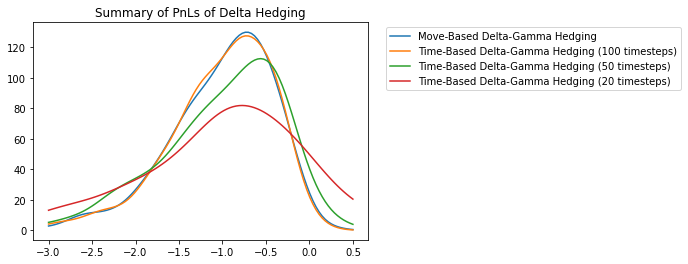

In [226]:
def PlotMetrics_d_PnL_pq2(PnL1,PnL2,PnL3,PnL4,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-3,0.5,100)
    hist_bins = np.linspace(-3,0.5,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.legend(['Move-Based Delta-Gamma Hedging','Time-Based Delta-Gamma Hedging (100 timesteps)',\
               'Time-Based Delta-Gamma Hedging (50 timesteps)','Time-Based Delta-Gamma Hedging (20 timesteps)'],\
                 bbox_to_anchor=(1.95,1),loc="upper right")
    plt.title(mytitle)
    plt.show()
PlotMetrics_d_PnL_pq2(tmove_PnLq,ttime_PnLq,ttime_PnLq50,ttime_PnLq20,"Summary of PnLs of Delta Hedging")

In [227]:
# deltagamma hedging when p_sigma=0.25, q_sigma=0.2
# deltagamma hedging when timestep=100
tt1qg,tprice_pqg,tSx,ttime_Yqg,tmove_Yqg,ttime_alphaqg,tmove_alphaqg,\
ttime_PnLqg,tmove_PnLqg,tmove_BVqg,ttime_BVqg,ttranscost_timeqg,ttranscost_moveqg,\
ttime_gammaqg,tmove_gammaqg=\
DeltaGammaHedge(mystock3,S0,mu,q_sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.05)
# deltagamma hedging when timestep=50
tt_50qg,tprice_50qg,tS_50qg,ttime_Y_50qg,tmove_Y_50qg, \
ttime_alpha_50qg,tmove_alpha_50qg,ttime_PnL_50qg,tmove_PnL_50qg,tmove_BV_50qg,ttime_BV_50qg,\
                             ttranscost_time_50qg,ttranscost_move_50qg,ttime_gamma_50qg,tmove_gamma_50qg=\
DeltaGammaHedge(mystock3,S0,mu,sig,r,K,T1,T2,Ndt_1,50,Nsims_1,cost_e,cost_o,0.05)
# deltagamma hedging when timestep=20
tt_20qg,price_20qg,tS_20qg,ttime_Y_20qg,tmove_Y_20qg, ttime_alpha_20qg, tmove_alpha_20qg,\
ttime_PnL_20qg,move_PnL_20qg,tmove_BV_20qg,ttime_BV_20qg,\
                             ttranscost_time_20qg,ttranscost_move_20qg,ttime_gamma_20qg,tmove_gamma_20qg =\
DeltaGammaHedge(mystock3,S0,mu,sig,r,K,T1,T2,Ndt_1,20,Nsims_1,cost_e,cost_o,0.05)

In [257]:
print(np.mean(tmove_PnLqg))
print(np.mean(ttime_PnLqg))
print(np.mean(ttime_PnL_50qg))
print(np.mean(ttime_PnL_20qg))
print(np.std(tmove_PnLqg))
print(np.std(ttime_PnLqg))
print(np.std(ttime_PnL_50qg))
print(np.std(ttime_PnL_20qg))
print(np.mean(tmove_PnLqg[tmove_PnLqg<=np.quantile(tmove_PnLqg,0.1)]))
print(np.mean(ttime_PnLqg[ttime_PnLqg<=np.quantile(ttime_PnLqg,0.1)]))
print(np.mean(ttime_PnL_50qg[ttime_PnL_50qg<=np.quantile(ttime_PnL_50qg,0.1)]))
print(np.mean(ttime_PnL_20qg[ttime_PnL_20qg<=np.quantile(ttime_PnL_20qg,0.1)]))

-0.16334866304686743
-0.1757195560986211
-0.13726662926955155
-0.10189175589843083
0.12727177935298406
0.12761100446885582
0.1481264451577712
0.2646835807092429
-0.446809208250746
-0.463779752155201
-0.4590050121019903
-0.6070586337753172


In [259]:
payoff3 = 100 - mystock3[:,-1]
payoff3[payoff3<0]=0
print(np.mean(tmove_BVqg[:,-1]-payoff3))
print(np.mean(ttime_BVqg[:,-1] - payoff3))
print(np.mean(ttime_BV_50qg[:,-1]-payoff3))
print(np.mean(ttime_BV_20qg[:,-1]-payoff3))
print(np.mean(ttranscost_moveqg))
print(np.mean(ttranscost_timeqg))
print(np.mean(ttranscost_time_50qg))
print(np.mean(ttranscost_time_20qg))

-0.1510536513404072
-0.1634572796529233
-0.12500435282385375
-0.08851265006135454
0.17771124581554823
0.18846345261107053
0.14992610033221201
0.10815598277925455


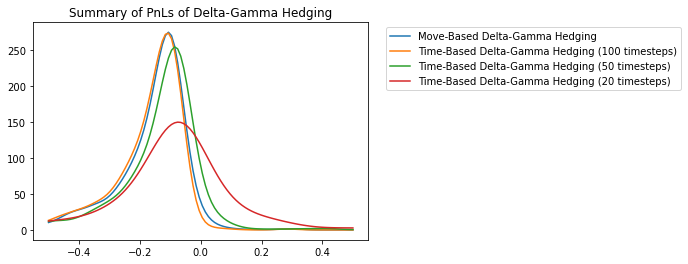

In [273]:
PlotMetrics_dg_PnL_pq(tmove_PnLqg,ttime_PnLqg,ttime_PnL_50qg,ttime_PnL_20qg,"Summary of PnLs of Delta-Gamma Hedging")

## Q4

In [146]:
## delta hedging when band-width = 0.01
t01, price01, S01, time_Y01, move_Y01, time_alpha01, move_alpha01, time_PnL01, move_PnL01, move_BV01,time_BV01,\
 transcost_time01,transcost_move01 \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o, 0.01)
## delta hedging when band-width = 0.03
t03, price03, S03, time_Y03, move_Y03, time_alpha03, move_alpha03, time_PnL03, move_PnL03, move_BV03,time_BV03,\
transcost_time03,transcost_move03 \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o, 0.03)
## delta hedging when band-width = 0.1
t10, price10, S10, time_Y10, move_Y10, time_alpha10, move_alpha10, time_PnL10, move_PnL10, move_BV10,time_BV10,\
transcost_time10,transcost_move10 \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o, 0.1)
## delta hedging when band-width = 0.15
t15, price15, S15, time_Y15, move_Y15, time_alpha15, move_alpha15, time_PnL15, move_PnL15, move_BV15,time_BV15,\
transcost_time15,transcost_move15 \
                              = DeltaHedge(mystock,S0,mu,sig,r,K,T1,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o, 0.15)

In [265]:
payoff1 = 100 - mystock[:,-1]
payoff1[payoff1<0]=0
print(np.mean(move_BV01[:,-1]-payoff1))
print(np.mean(move_BV03[:,-1] - payoff1))
print(np.mean(move_BV[:,-1]-payoff1))
print(np.mean(move_BV10[:,-1]-payoff1))
print(np.mean(move_BV15[:,-1]-payoff1))

-0.022090000839549134
-0.022135810617462306
-0.015662282156725143
-0.02480386718999804
-0.013769999979442506


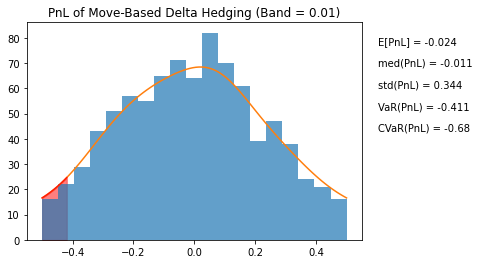

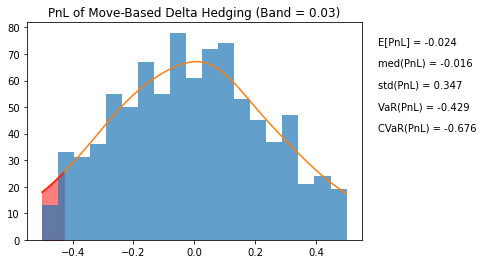

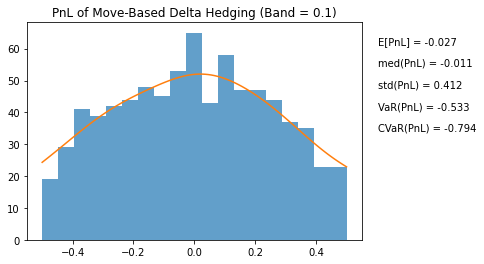

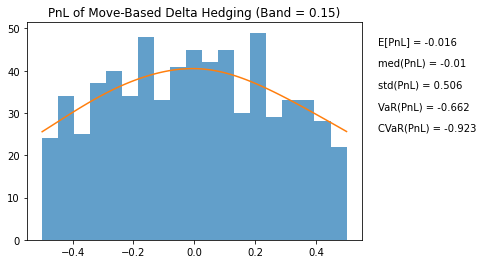

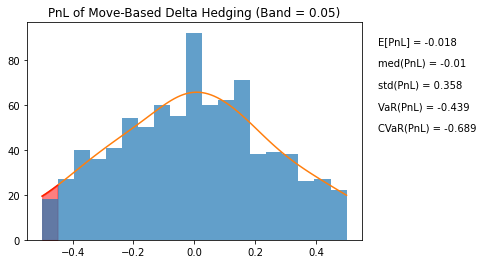

In [261]:
PlotMetrics(move_PnL01,"PnL of Move-Based Delta Hedging (Band = 0.01)")
PlotMetrics(move_PnL03,"PnL of Move-Based Delta Hedging (Band = 0.03)")
PlotMetrics(move_PnL10,"PnL of Move-Based Delta Hedging (Band = 0.1)")
PlotMetrics(move_PnL15,"PnL of Move-Based Delta Hedging (Band = 0.15)")
PlotMetrics(move_PnL,"PnL of Move-Based Delta Hedging (Band = 0.05)")

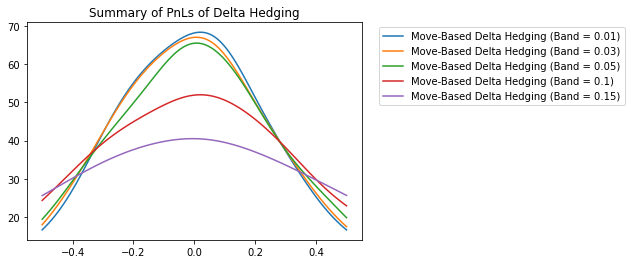

In [274]:
def PlotMetrics_d_PnL_band(PnL1,PnL2,PnL3,PnL4,PnL5,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-0.5,0.5,100)
    hist_bins = np.linspace(-0.5,0.5,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde5 = KDE(PnL5, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.plot(kde_bins, kde5)
    ax.legend(['Move-Based Delta Hedging (Band = 0.01)','Move-Based Delta Hedging (Band = 0.03)',\
               'Move-Based Delta Hedging (Band = 0.05)','Move-Based Delta Hedging (Band = 0.1)',\
               'Move-Based Delta Hedging (Band = 0.15)'],\
                 bbox_to_anchor=(1.8,1),loc="upper right")
    plt.title(mytitle)
    plt.show()
PlotMetrics_d_PnL_band(move_PnL01,move_PnL03,move_PnL,move_PnL10,move_PnL15,"Summary of PnLs of Delta Hedging")

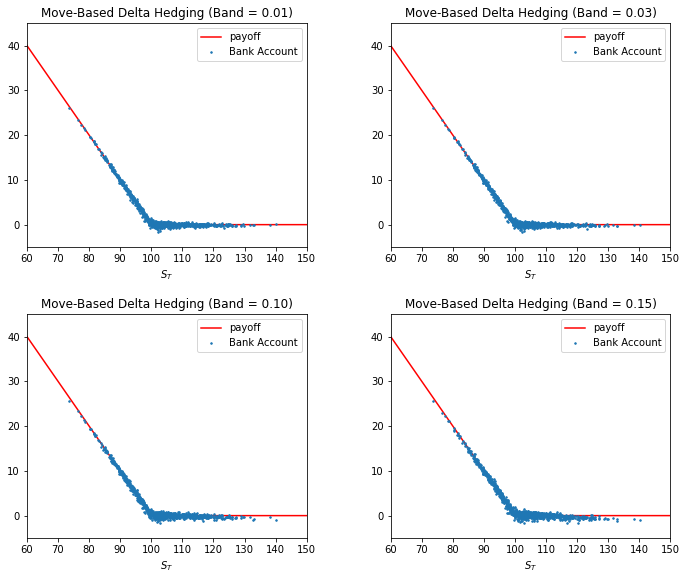

In [268]:
plt.figure(figsize=(6.5,6.5))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y01[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.01)')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y03[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.03)')

plt.subplot(2,2,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y10[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.10)')

plt.subplot(2,2,4)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y15[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.15)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.3,hspace=0.3)

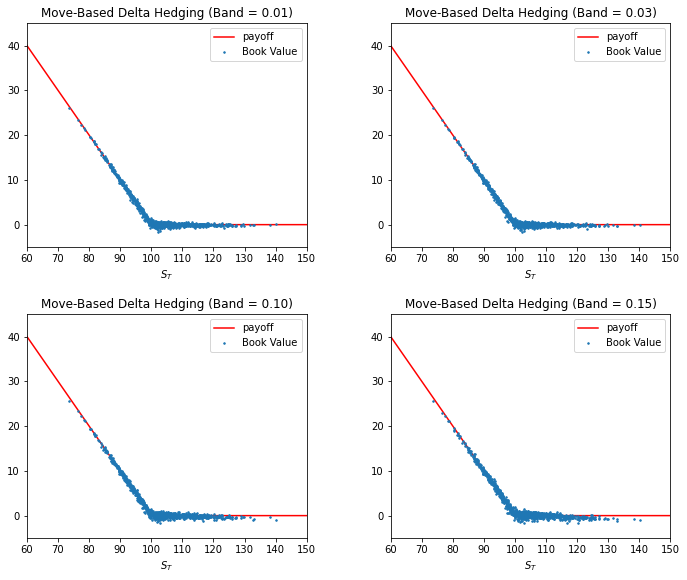

In [269]:
plt.figure(figsize=(6.5,6.5))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV01[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.01)')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV03[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.03)')

plt.subplot(2,2,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV10[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.10)')

plt.subplot(2,2,4)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV15[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta Hedging (Band = 0.15)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.3,hspace=0.3)

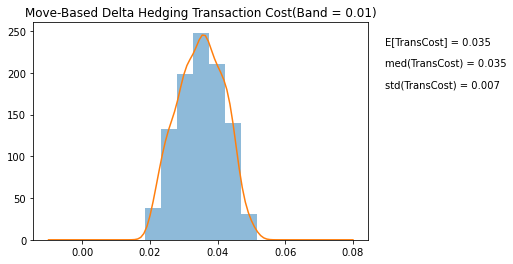

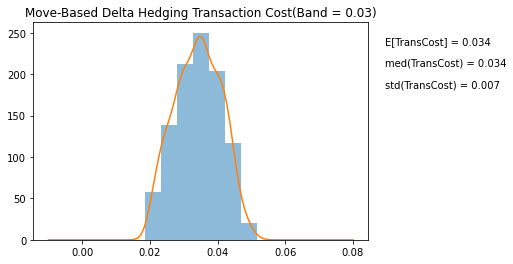

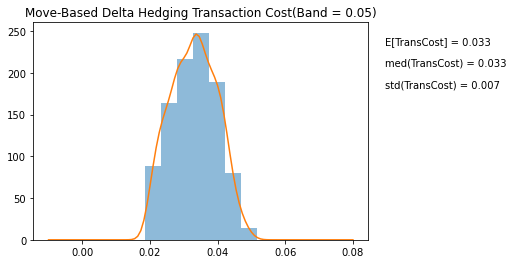

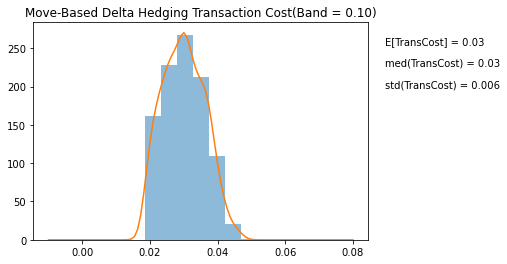

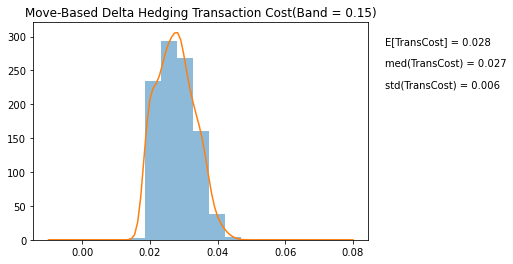

In [150]:
PlotMetrics2(transcost_move01,"Move-Based Delta Hedging Transaction Cost(Band = 0.01)")
PlotMetrics2(transcost_move03,"Move-Based Delta Hedging Transaction Cost(Band = 0.03)")
PlotMetrics2(transcost_move,"Move-Based Delta Hedging Transaction Cost(Band = 0.05)")
PlotMetrics2(transcost_move10,"Move-Based Delta Hedging Transaction Cost(Band = 0.10)")
PlotMetrics2(transcost_move15,"Move-Based Delta Hedging Transaction Cost(Band = 0.15)")

In [158]:
## delta-gamma hedging with different bands
# deltagamma hedging when band = 0.01
t01g,price_p01g,S01g,time_Y01g,move_Y01g, time_alpha01g, move_alpha01g,\
time_PnL01g,move_PnL01g,move_BV01g,time_BV01g,transcost_time01g,transcost_move01g,time_gamma01g,move_gamma01g=\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.01)
# deltagamma hedging when band = 0.03
t03g,price03g,S03g,time_Y03g,move_Y03g, time_alpha03g, move_alpha03g,time_PnL03g,move_PnL03g,move_BV03g,time_BV03g,\
                             transcost_time03g,transcost_move03g,time_gamma03g,move_gamma03g=\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.03)
# deltagamma hedging when tband = 0.1
t10g,price10g,S10g,time_Y10g,move_Y10g, time_alpha10g, move_alpha10g,time_PnL10g,move_PnL10g,move_BV10g,time_BV10g,\
                             transcost_time10g,transcost_move10g,time_gamma10g,move_gamma10g=\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.1)
# deltagamma hedging when tband = 0.15
t15g,price15g,S03g,time_Y15g,move_Y15g, time_alpha15g, move_alpha15g,time_PnL15g,move_PnL15g,move_BV15g,time_BV15g,\
                             transcost_time15g,transcost_move15g,time_gamma15g,move_gamma15g=\
DeltaGammaHedge(mystock,S0,mu,sig,r,K,T1,T2,Ndt_1,timestep_1,Nsims_1,cost_e,cost_o,0.15)

In [266]:
payoff1 = 100 - mystock[:,-1]
payoff1[payoff1<0]=0
print(np.mean(move_BV01g[:,-1]-payoff1))
print(np.mean(move_BV03g[:,-1] - payoff1))
print(np.mean(move_BVx[:,-1]-payoff1))
print(np.mean(move_BV10g[:,-1]-payoff1))
print(np.mean(move_BV15g[:,-1]-payoff1))

-0.14449888591843046
-0.1407631498377576
-0.13617896632610593
-0.12719909344123512
-0.11824642705968637


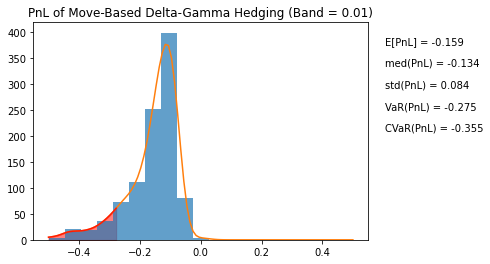

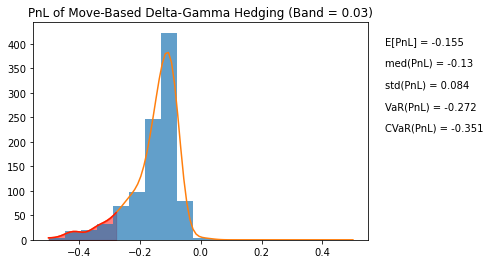

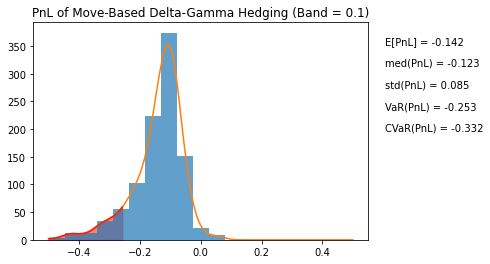

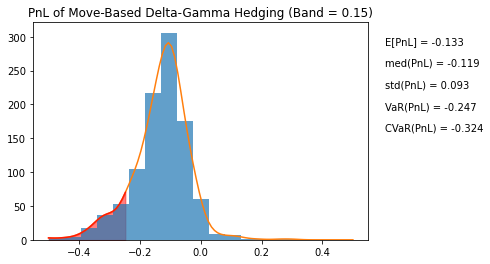

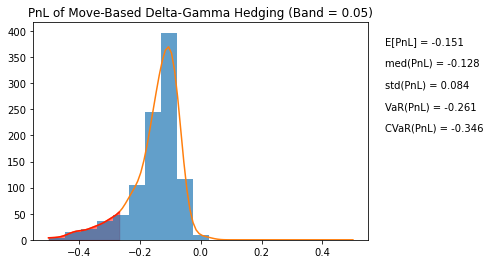

In [262]:
PlotMetrics(move_PnL01g,"PnL of Move-Based Delta-Gamma Hedging (Band = 0.01)")
PlotMetrics(move_PnL03g,"PnL of Move-Based Delta-Gamma Hedging (Band = 0.03)")
PlotMetrics(move_PnL10g,"PnL of Move-Based Delta-Gamma Hedging (Band = 0.1)")
PlotMetrics(move_PnL15g,"PnL of Move-Based Delta-Gamma Hedging (Band = 0.15)")
PlotMetrics(move_PnLx,"PnL of Move-Based Delta-Gamma Hedging (Band = 0.05)")

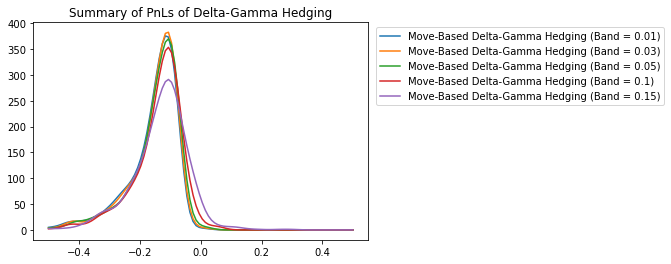

In [275]:
def PlotMetrics_dg_PnL_band(PnL1,PnL2,PnL3,PnL4,PnL5,mytitle):    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kde_bins = np.linspace(-0.5,0.5,100)
    hist_bins = np.linspace(-0.5,0.5,20)
    kde1 = KDE(PnL1, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde2 = KDE(PnL2, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde3 = KDE(PnL3, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde4 = KDE(PnL4, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    kde5 = KDE(PnL5, kde_bins)*Nsims_1*(hist_bins[1]-hist_bins[0])
    ax.plot(kde_bins, kde1)
    ax.plot(kde_bins, kde2)
    ax.plot(kde_bins, kde3)
    ax.plot(kde_bins, kde4)
    ax.plot(kde_bins, kde5)
    ax.legend(['Move-Based Delta-Gamma Hedging (Band = 0.01)','Move-Based Delta-Gamma Hedging (Band = 0.03)',\
               'Move-Based Delta-Gamma Hedging (Band = 0.05)','Move-Based Delta-Gamma Hedging (Band = 0.1)',\
               'Move-Based Delta-Gamma Hedging (Band = 0.15)'],\
                 bbox_to_anchor=(1.9,1),loc="upper right")
    plt.title(mytitle)
    plt.show()
PlotMetrics_dg_PnL_band(move_PnL01g,move_PnL03g,move_PnLx,move_PnL10g,move_PnL15g,"Summary of PnLs of Delta-Gamma Hedging")

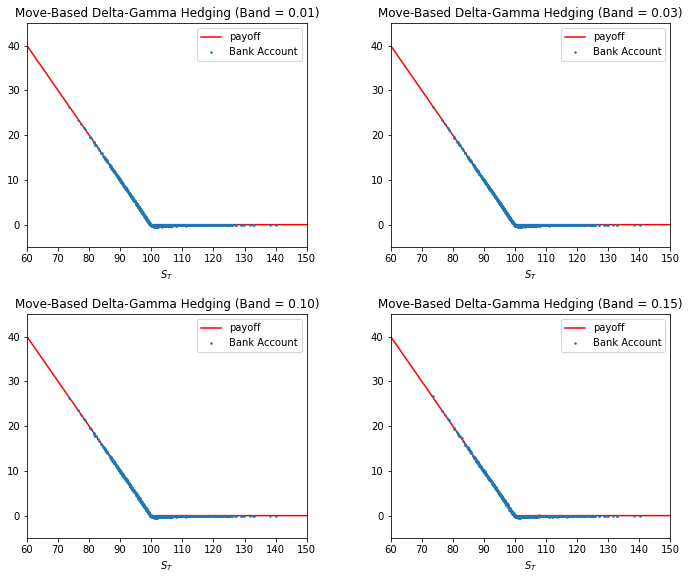

In [271]:
plt.figure(figsize=(6.5,6.5))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y01g[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.01)')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y03g[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.03)')

plt.subplot(2,2,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y10g[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.10)')

plt.subplot(2,2,4)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_Y15g[:,-1],'.',markersize=3, label='Bank Account')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.15)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.3,hspace=0.3)

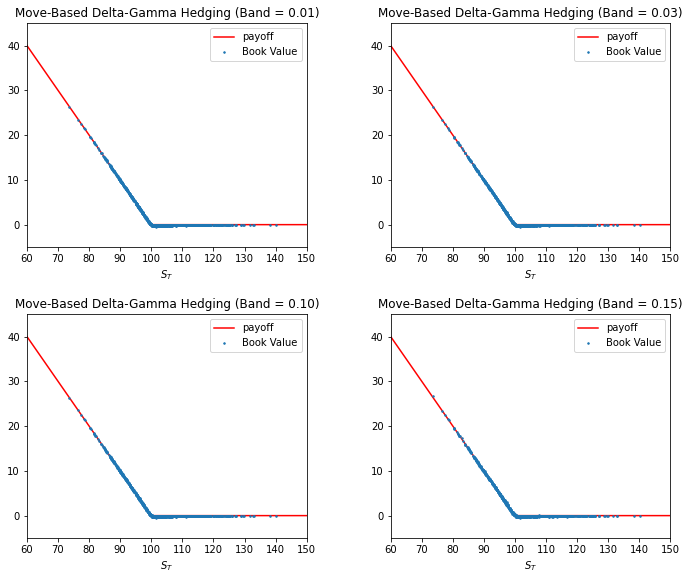

In [272]:
plt.figure(figsize=(6.5,6.5))
plt.subplot(2,2,1)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV01g[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.01)')

plt.subplot(2,2,2)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV03g[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.03)')

plt.subplot(2,2,3)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV10g[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.10)')

plt.subplot(2,2,4)
plt.plot(np.linspace(60,150,100), np.maximum(K-np.linspace(60,150,100),0),'-r', label='payoff')
plt.plot(mystock[:,-1], move_BV15g[:,-1],'.',markersize=3, label='Book Value')
plt.xlabel('$S_T$')
plt.ylim(-5,45)
plt.xlim(60,150)
plt.legend()
plt.title('Move-Based Delta-Gamma Hedging (Band = 0.15)')
plt.subplots_adjust(left=0.125,bottom=0.1,right=1.5,top=1.2,wspace=0.3,hspace=0.3)

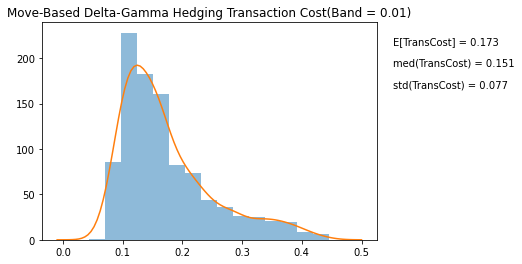

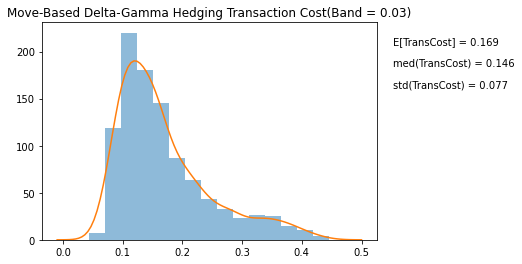

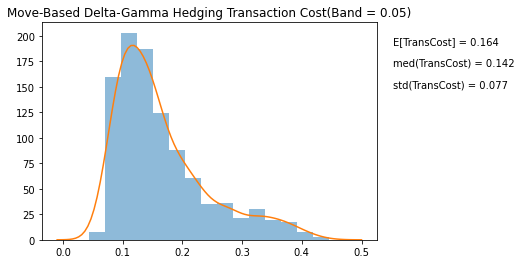

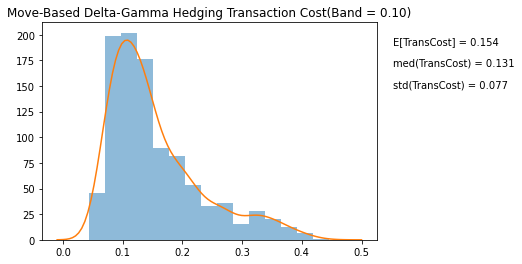

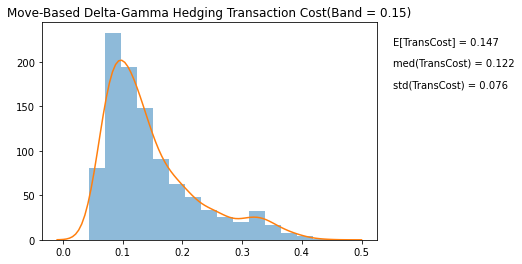

In [160]:
PlotMetrics3(transcost_move01g,"Move-Based Delta-Gamma Hedging Transaction Cost(Band = 0.01)")
PlotMetrics3(transcost_move03g,"Move-Based Delta-Gamma Hedging Transaction Cost(Band = 0.03)")
PlotMetrics3(transcost_movex,"Move-Based Delta-Gamma Hedging Transaction Cost(Band = 0.05)")
PlotMetrics3(transcost_move10g,"Move-Based Delta-Gamma Hedging Transaction Cost(Band = 0.10)")
PlotMetrics3(transcost_move15g,"Move-Based Delta-Gamma Hedging Transaction Cost(Band = 0.15)")